# About cvs_skills_analysis.ipynb
This notebook reports different statistics and visuals on the use of CVS like skills by students

In [1]:
%load_ext autoreload
%autoreload 1
%aimport utils_timeline_viz
from utils_timeline_viz import *
from utils_read_parsing import *
import matplotlib.pyplot as plt
from tabulate import tabulate
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 10, 7
from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('precision',3)
np.set_printoptions(precision=3,suppress=True)

# Preparing the data
First we load the data generated by the cvs_skills_detector.ipynb
We also grab the order in which students did the activities using the metadata file and we adjust the detection of CVS given how large the sample size should be to consider use of CVS.

We also load a copy of the data but binarized to facilitate analysis.

In [2]:
table_cvs_df = pd.read_csv('table_cvs_results.txt', sep='\t')
graph_cvs_df = pd.read_csv('graph_cvs_results.txt', sep='\t')

In [3]:
metadf = get_student_metadata()
order = dict(zip(metadf.index,metadf['activity order']))
graph_cvs_df['activity order'] = graph_cvs_df.studentid.apply(lambda sid: order[sid])
table_cvs_df['activity order'] = table_cvs_df.studentid.apply(lambda sid: order[sid])

In [4]:
graph_cvs_df = graph_cvs_df.replace(to_replace=2,value=0)
table_cvs_df = table_cvs_df.replace(to_replace=2,value=0)
print len(table_cvs_df),len(graph_cvs_df)

149 149


In [5]:
variables = ["Battery voltage","Area","Separation","Wavelength","Width","Concentration"]

def binarize(number):
    if number >0:
        return 1
    else:
        return 0

graph_cvs_df2 = graph_cvs_df.copy()
for c in graph_cvs_df:
    if c not in  ['studentid','activity order']:
        graph_cvs_df2[c] = graph_cvs_df.apply(lambda row: binarize(row[c]), axis=1)

table_cvs_df2 = table_cvs_df.copy()
for c in table_cvs_df:
     if c not in['studentid','activity order']:
        table_cvs_df2[c] = table_cvs_df.apply(lambda row: binarize(row[c]), axis=1)

graph_cvs_df2['sum'] = graph_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum'] = table_cvs_df2[variables].sum(axis=1)
table_cvs_df2['sum caps'] = table_cvs_df2[['Battery voltage','Area','Separation']].sum(axis=1)
table_cvs_df2['sum beers'] = table_cvs_df2[["Wavelength","Width","Concentration"]].sum(axis=1)

In [6]:
print "Of all {0} students, {1} didn't do CVS in the table and {2} in the graph.".format(len(table_cvs_df2), sum(table_cvs_df2['sum']==0),sum(graph_cvs_df2['sum']==0))
print "On average, out of a max of six variables, students did CVS on {0}+/-{1} variables in the table and {2}+/-{3} in the graph.".format(np.mean(table_cvs_df2['sum'].values),np.std(table_cvs_df2['sum'].values),np.mean(graph_cvs_df2['sum'].values),np.std(graph_cvs_df2['sum'].values))
table_cvs_df.head()

Of all 149 students, 14 didn't do CVS in the table and 47 in the graph.
On average, out of a max of six variables, students did CVS on 3.41610738255+/-2.04020222429 variables in the table and 2.34899328859+/-2.06578445862 in the graph.


,studentid,Battery voltage,Area,Separation,Wavelength,Width,Concentration,activity order
0,11612162,0,0,0,3,0,3,CL
1,13660166,0,0,0,0,0,14,LC
2,41947147,0,0,0,14,6,7,CL
3,64006159,0,0,0,5,0,6,LC
4,15749160,0,0,3,0,4,10,CL


# CVS in the table

## How many students are doing CVS for each variable?

In [7]:
print "Percentage of students doing CVS for variable in table."
p = [['',' %']]
for v in variables:
    p.append([c,round(np.mean(table_cvs_df2[v].values)*100,1)])
print tabulate(p)

Percentage of students doing CVS for variable in table.
--------------  ----
                %
activity order  47.7
activity order  56.4
activity order  53.0
activity order  59.7
activity order  59.7
activity order  65.1
--------------  ----


## When they do CVS, how many points do they take?

In [8]:
print "Mean sample size for each variable, excluding zeroes."
p = [['',' Mean number of pts']]
for v in variables:
    p.append([c,round(np.mean(table_cvs_df[table_cvs_df[v]!=0][v].values),1)])
print tabulate(p)

Mean sample size for each variable, excluding zeroes.
--------------  ------------------
                Mean number of pts
activity order  5.9
activity order  6.0
activity order  5.8
activity order  8.3
activity order  6.8
activity order  6.4
--------------  ------------------


## Great so they use it, but are students consistent in their use of CVS accross sims?

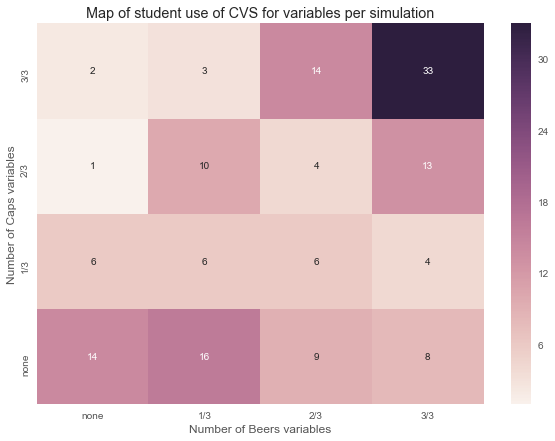

In [9]:
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum beers']==j)])
ax = sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d")
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Beers variables')
plt.ylabel('Number of Caps variables')
plt.title('Map of student use of CVS for variables per simulation')

Overall their behavior is not consistent between sims (absence of diagonal). However students who use CVS on 2 or 3 variables tend to do so for both sims (heavy upper corner). Another pattern we see is that students who do not use CVS in the capacitance sim are still 70% likely to use CVS in the beers sim (lowest row: (16+9+8=) 35 students out of (14+16+9+8=) 49).

* Heavy use of CVS is consitent
* Low use of CVS is different between sims

## Does order matter in their consistency?

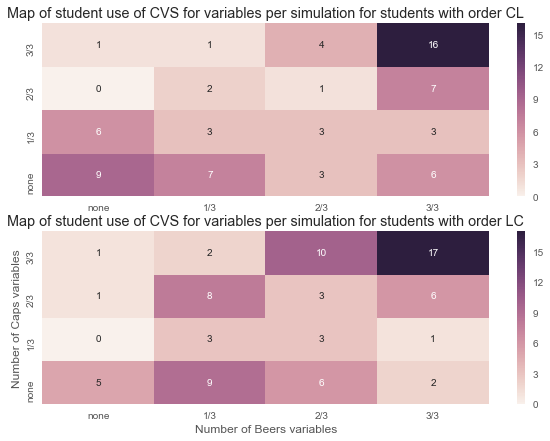

In [10]:
f, (ax1, ax2) = plt.subplots(2)
ax = ax1
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum beers']==j)&(table_cvs_df2['activity order']=='CL')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d",ax=ax1)
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Beers variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS for variables per simulation for students with order CL')

ax = ax2
cvs_sim = np.zeros((4,4),dtype=int)
for i in range(4):
    for j in range(4):
        cvs_sim[i,j] = len(table_cvs_df2[(table_cvs_df2['sum caps']==i)&(table_cvs_df2['sum beers']==j)&(table_cvs_df2['activity order']=='LC')])
sns.heatmap(np.flip(cvs_sim,0),annot=True, fmt="d", ax=ax2)
ax.set_xticklabels(['none','1/3','2/3','3/3'])
ax.set_yticklabels(['none','1/3','2/3','3/3'])
plt.xlabel('Number of Beers variables')
plt.ylabel('Number of Caps variables')
ax.set_title('Map of student use of CVS for variables per simulation for students with order LC')

Asymetry everywheerererer

## Let's dig deeper into how order matters and how the sims are different/same and what that tells us about student learning inquiry.
## Does order matter in terms of the number of points in they CVS? (More = more deliberate, better sampling)